In [1]:
import gym

env = gym.make("Taxi-v3").env

env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Q-values are initialized to an arbitrary value, and as the agent exposes itself to the environment and receives different rewards by executing different actions, the Q-values are updated using the equation:

***Q(state,action)←(1−α)Q(state,action)+α(reward+γmaxaQ(next state,all actions))***

Where:

- α (alpha) is the learning rate (0<α≤1) - Just like in supervised learning settings, α is the extent to which our Q-values are being updated in every iteration.

- γ (gamma) is the discount factor (0≤γ≤1) - determines how much importance we want to give to future rewards. A high value for the discount factor (close to 1) captures the long-term effective award, whereas, a discount factor of 0 makes our agent consider only immediate reward, hence making it greedy.

In [2]:
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [3]:
env.reset() # reset environment to a new, random state
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


The **blue** letter represents the current passenger *pick-up location*, and the **purple** letter is the *current destination*.

In [4]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



When the Taxi environment is created, there is an initial Reward table that's also created, called `P`. We can think of it like a matrix that has the **number of states as rows and number of actions as columns**, i.e. a **states × actions** matrix.

This dictionary has the structure {action: [(probability, nextstate, reward, done)]}

0-5 corresponds to the actions (south, north, east, west, pickup, dropoff)

In [5]:
env.P[328]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

In [6]:
env.s

328

In [7]:
env.step(0)

(428, -1, False, {'prob': 1.0})

In [8]:
env.P[428]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 328, -1, False)],
 2: [(1.0, 448, -1, False)],
 3: [(1.0, 428, -1, False)],
 4: [(1.0, 428, -10, False)],
 5: [(1.0, 428, -10, False)]}

In [9]:
env.step(1)

(328, -1, False, {'prob': 1.0})

# BRUTE FORCE

In [10]:
env.s = 328  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames = [] 
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 483
Penalties incurred: 165


In [11]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 1
State: 0
Action: 5
Reward: 20


# Q-Learning

In [12]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [13]:
%%time
%matplotlib inline

"""Training the agent"""

import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns


# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1
            all_penalties.append(penalties)
        else:
            all_penalties.append(0)
            

        state = next_state
        epochs += 1
        all_epochs.append(epochs)
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")


Episode: 100000
Training finished.

Wall time: 55.4 s


In [14]:
%%time
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    frames = []
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1
        
        frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
            }
        )
        epochs += 1
    if total_epochs%4 == 0:
        for i, frame in enumerate(frames):
            clear_output(wait=True)
            print(frame['frame'])
            print(f"Timestep: {i + 1}")
            print(f"State: {frame['state']}")
            print(f"Action: {frame['action']}")
            print(f"Reward: {frame['reward']}")
            print(f"Epoch No.: {total_epochs}")
            sleep(.1)

    total_penalties += penalties
    total_epochs += epochs
    
print()
print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 10
State: 475
Action: 5
Reward: 20
Epoch No.: 1272

Results after 100 episodes:
Average timesteps per episode: 12.97
Average penalties per episode: 0.0
Wall time: 31.1 s


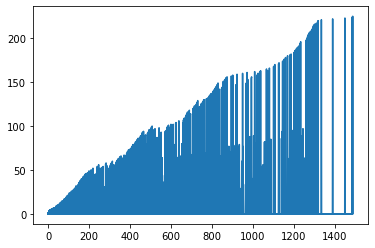

In [15]:
plt.plot(all_epochs,all_penalties)